# ML4SETI Code Challenge Winning Model

This notebook shows you how to run the winning model from the [ML4SETI code challenge](https://github.com/setiquest/ml4seti); a public code challenge issued by IBM and the SETI Insititute in the summer of 2017. The challenge was to build the best signal classification model from a set of simulated (and labeled) radio-telescope data files. These time-series simulated measurements, much like the real data acquired by the SETI Institute during observations at the Allen Telescope Array, were converted to spectrograms, represented as 2D images, and used to train various machine-learning models. 

The [1st place team](https://compete.cognitiveclass.ai/event/5957f1ec13880a001fd89bd7/leaderboard), [Effsubsee](https://github.com/sgrvinod/ml4seti-Effsubsee), achieved a classification accuracy of 94.9% used "an averaged ensemble of 5 [Wide Residual Networks](https://arxiv.org/abs/1605.07146), trained on different sets of 4(/5) folds, each with a depth of 34 (convolutional layers) and a widening factor of 2." (NB: Effsubsee, is $F_{c}$, from [the Drake Equation](http://www.seti.org/drakeequation), which represents "The fraction of civilizations that develop a technology that releases detectable signs of their existence into space.")

The code below will install the necessary Python packages, Effsubsee's model, and demonstrate how to use that model to classify a simulated data file from one of the test sets. 


<br>
## Install Packages

In [ ]:
# Uncomment and run this one time only

# !pip install http://download.pytorch.org/whl/cu75/torch-0.1.12.post2-cp27-none-linux_x86_64.whl
# !pip install torchvision==0.1.8
# !pip install tabulate
# !pip install --upgrade scikit-learn
# !pip install --upgrade numpy
# !pip install h5py
# !pip install ibmseti
# !pip install tqdm
# !pip install --upgrade pandas

<br>
## Download Effsubsee's model

#### Model stored in IBM Object Storage

The parameters for our models have been placed in an [IBM Cloud Object Storage](https://console.bluemix.net/docs/services/ObjectStorage/os_works_public.html) service instance. The Access Control Lists for the containers in Object Storage have been set such that the objects in those containers are publicly available. 

In [ ]:
# Uncomment and run this one time only!

# from __future__ import print_function
# import requests
# import shutil

# base_url = 'https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b/code_challenge_models/effsubsee'
# for i in range(1,6):
#     r = requests.get('{0}/fold{1}/FOLD{1}_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar'.format(base_url, i), stream=True)
#     filename = 'effsubsee_FOLD{}_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar'.format(i)
#     with open(filename, 'wb') as fout:
#         shutil.copyfileobj(r.raw, fout)
#     print('saved {}'.format(filename))

In [ ]:
# Uncomment and run this once

# !wget -O mean_stddev_primary_full_v3__384t__512f__logmod2-ph.hdf5 https://github.com/sgrvinod/ml4seti-Effsubsee/blob/master/folds/mean_stddev_primary_full_v3__384t__512f__logmod2-ph.hdf5?raw=true

<br>
## Download the Preview Test Set

In [7]:
# Uncomment and run this one time only

# !wget https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b/simsignals_v3_zipped/primary_testset_preview_v3.zip
# !unzip -q primary_testset_preview_v3.zip
# !ls

effsubsee_FOLD1_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar
effsubsee_FOLD2_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar
effsubsee_FOLD3_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar
effsubsee_FOLD4_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar
effsubsee_FOLD5_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar
mean_stddev_primary_full_v3__384t__512f__logmod2-ph.hdf5
primary_testset_preview_v3
primary_testset_preview_v3.zip


<br>
# Restart Your Kernel

After you've `pip install`ed the packages above, you'll need to restart your kernel. 

1. Comment out the code in the cells above *(within a cell you drag and select the lines of code then press Command+'/', or Ctrl+'/', to comment and uncomment entire blocks of code)*
2. In the menu above select Kernel -> Restart.
3. Run the cells below



## Adapted from https://github.com/sgrvinod/ml4seti-Effsubsee

This code, for now, is found in https://github.com/gadamc/ml4seti-Effsubsee/

In [1]:
import math
from torch import nn


class BasicBlock(nn.Module):
    """
    Graph of the Basic Block, as defined in the paper.
    This block contains two 3x3 convolutional layers, each with prior Batch Norm and ReLU.
    There is an additive residual connection across the block.
    If the number of dimensions change across the block, this residual is a convolutional projection of the input.
    Args:
        inplanes (int): number of dimensions in the input tensor.
        outplanes (int): number of dimensions in the output tensor.
        stride (int): stride length for the filter.
        dropout (float, fraction): the fraction of neurons to randomly drop/set to zero in-between conv. layers.
    """

    def __init__(self, inplanes, outplanes, stride, dropout=0.0):
        super(BasicBlock, self).__init__()

        self.inplanes = inplanes
        self.outplanes = outplanes

        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(inplanes, outplanes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(outplanes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(outplanes, outplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.dropout = dropout
        if self.inplanes != self.outplanes:
            self.projection = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=stride, padding=0, bias=False)
        else:
            self.projection = None

    def forward(self, x):
        out = self.bn1(x)
        out = self.relu1(out)
        if self.inplanes != self.outplanes:
            residual = self.projection(out)
        else:
            residual = x
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu2(out)
        if self.dropout > 0.:
            out = nn.functional.dropout(out, p=self.dropout, training=self.training)
        out = self.conv2(out)
        out += residual
        return out




class WideResNet(nn.Module):
    """
    Graph of the Wide Residual Network, as defined in the paper.
    This network contains 4 convolutional blocks, each increasing dimensions by a factor of 'k':
    The first is a single 3x3 Convolution, increasing dimensions from 2 (log(amplitude^2), phase) to 16.
    The second is a sequence of Basic Blocks, 16 dimensions -> 16*k
    The third is a sequence of Basic Blocks, 16*k dimensions -> 16*k^2
    The fourth is a sequence of Basic Blocks, 16*k dimensions -> 16*k^3
    These convolutional layers are followed by Batch Norm, ReLU, Average Pool, and finally a Fully Connected Layer
    to perform the classification.
    Args:
        n (int): number of single convolutional layers in the entire network, 'n' in the paper.
        k (int): widening factor for each succeeding convolutional layer, 'k' in the paper.
        block (nn.module): BasicBlock.
        dropout (float, fraction): the fraction of neurons to randomly drop/set to zero inside the blocks.
    """

    def __init__(self, n, k, block=BasicBlock, dropout=0.0):
        super(WideResNet, self).__init__()

        if (n - 4) % 6 != 0:
            raise ValueError("Invalid depth! Depth must be (6 * n_blocks + 4).")
        n_blocks = (n - 4) / 6

        self.conv_block1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv_block2 = self._make_layer(block, n_blocks, 16, 16 * k, 2, dropout)
        self.conv_block3 = self._make_layer(block, n_blocks, 16 * k, 32 * k, 2, dropout)
        self.conv_block4 = self._make_layer(block, n_blocks, 32 * k, 64 * k, 2, dropout)
        self.bn1 = nn.BatchNorm2d(64 * k)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(64 * k * 6 * 8, 7)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n_weights = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n_weights))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_layer(self, block, n_blocks, inplanes, outplanes, stride, dropout):
        """
        Graph of a Convolutional block layer (conv_block2/conv_block3/conv_block4), as defined in the paper.
        This graph assembles a number of blocks (BasicBlock) in sequence.
        Args:
            block (nn.module): BasicBlock or ResidualBlock.
            inplanes (int): number of dimensions in the input tensor.
            outplanes (int): number of dimensions in the output tensor.
            stride (int): stride length for the filter.
            dropout (float, fraction): the fraction of neurons to randomly drop/set to zero in-between conv. layers.
            """
        layers = []
        for i in range(n_blocks):
            if i == 0:
                layers.append(block(inplanes, outplanes, stride, dropout))
            else:
                layers.append(block(outplanes, outplanes, 1, dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        out = self.conv_block3(out)
        out = self.conv_block4(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = nn.functional.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        return self.fc(out)


def wresnet34x2():
    model = WideResNet(n=34, k=2, block=BasicBlock, dropout=0.3)
    return model


In [2]:
from __future__ import print_function
import argparse
import os
import time
import torch
import torchvision.transforms as transforms
import pandas as pd
import ibmseti
import numpy as np
import ibmseti
import h5py

    
def normalizeSimFile(normalizeData, simfile):
    # Load the Normalizer function
    h = h5py.File(normalizeData, 'r')
    mean = torch.FloatTensor(h['mean'][:])
    mean = mean.permute(2, 0, 1)
    std_dev = torch.FloatTensor(h['std_dev'][:])
    std_dev = std_dev.permute(2, 0, 1)
    h.close()
    normalize = transforms.Normalize(mean=mean,
                                     std=std_dev)

    # Load simulation data
    time_freq_resolution=(384, 512)
    aca = ibmseti.compamp.SimCompamp(open(simfile, 'rb').read())
    complex_data = aca.complex_data()
    complex_data = complex_data.reshape(time_freq_resolution[0], time_freq_resolution[1])
    complex_data = complex_data * np.hanning(complex_data.shape[1])
    cpfft = np.fft.fftshift(np.fft.fft(complex_data), 1)
    spectrogram = np.abs(cpfft)
    features = np.stack((np.log(spectrogram ** 2),
                         np.arctan(cpfft.imag / cpfft.real)), -1)


    # create FloatTensor, permute to proper dimensional order, and normalize
    data = torch.FloatTensor(features)
    data = data.permute(2, 0, 1)
    data = normalize(data)

    # The model expects a 4D tensor
    s = data.size()
    data = data.contiguous().view(1, s[0], s[1], s[2])
        
    input_var = torch.autograd.Variable(data, volatile=True)
    
    return input_var


def singleProbs(model, input_var):
    """
    """

    model.eval()

    softmax = torch.nn.Softmax()
    softmax.zero_grad()
    output = model(input_var)
    probs = softmax(output).data.view(7).tolist()
    
    return probs


## Select a simulation file to test

You can change the simfile to any of the ~2500 files you choose in the primary_testset_preview_v3 folder

In [3]:
#!ls primary_testset_preview_v3/*

In [4]:
simfile = 'primary_testset_preview_v3/00b3b8fdb14ce41f341dbe251f476093.dat'

## Load the parameters for the models

In [5]:
allFolds = []

def loadFoldParams(modelcheckpoint):
    
    model = wresnet34x2().cpu()

    if os.path.isfile(modelcheckpoint):
        print("=> Loading checkpoint '{}'".format(modelcheckpoint))
        checkpoint = torch.load(modelcheckpoint, map_location=lambda storage, loc: storage)
        best_acc = checkpoint['best_acc']
        print("This model had an accuracy of %.2f on the validation set." % (best_acc,))
        keys = checkpoint['state_dict'].keys()
        for old_key in keys:
            new_key = old_key.replace('module.', '')
            checkpoint['state_dict'][new_key] = checkpoint['state_dict'].pop(old_key)
        model.load_state_dict(checkpoint['state_dict'])
        print("=> Loaded checkpoint '{}' (epoch {})"
              .format(modelcheckpoint, checkpoint['epoch']))
    else:
        print("=> No model checkpoint found. Exiting")
        return 
    
    allFolds.append(model)
    
def lf():
    for i in range(1,6):
        loadFoldParams('effsubsee_FOLD{}_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar'.format(i))
%time lf()

=> Loading checkpoint 'effsubsee_FOLD1_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar'
This model had an accuracy of 95.88 on the validation set.
=> Loaded checkpoint 'effsubsee_FOLD1_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar' (epoch 42)
=> Loading checkpoint 'effsubsee_FOLD2_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar'
This model had an accuracy of 95.74 on the validation set.
=> Loaded checkpoint 'effsubsee_FOLD2_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar' (epoch 37)
=> Loading checkpoint 'effsubsee_FOLD3_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar'
This model had an accuracy of 95.79 on the validation set.
=> Loaded checkpoint 'effsubsee_FOLD3_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar' (epoch 35)
=> Loading checkpoint 'effsubsee_FOLD4_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar'
This model had an accuracy of 95.65 on the validation set.
=> Loaded checkpoint 'effsubsee_FOLD4_BEST_wresnet34x2_batchsize96_checkpoint.pth.tar' (epoch 59)
=> Loading checkpoin

In [6]:
assert len(allFolds) == 5

In [7]:
# normalize the simulation data file
normalizer = 'mean_stddev_primary_full_v3__384t__512f__logmod2-ph.hdf5'
%time input_var = normalizeSimFile(normalizer, simfile)

CPU times: user 151 ms, sys: 15.9 ms, total: 167 ms
Wall time: 400 ms


<br>
## Calculate the class probabilities as an average of the probabilities returned by the 5 different networks

In [8]:
# calculate probabilities

def runAllModels(aSimFile):

    probs = np.zeros(7)
    for mf in allFolds:
        probs += singleProbs(mf, input_var)
    
    probs = probs/float(len(allFolds))
    return probs

%time probs = runAllModels(simfile)

CPU times: user 9min 12s, sys: 52.5 s, total: 10min 5s
Wall time: 17.2 s


<br>
## Display class probabilities and most-likely signal class

In [9]:
print('final class probabilities')
print(probs)

class_list = ['brightpixel', 'narrowband', 'narrowbanddrd', 'noise', 'squarepulsednarrowband', 'squiggle', 'squigglesquarepulsednarrowband']

print('signal classification')
predicted_signal_class = class_list[probs.argmax()]
print(predicted_signal_class)

final class probabilities
[  7.74400919e-07   6.25878969e-06   7.18993533e-06   6.34309807e-06
   9.62244523e-01   6.07969640e-08   3.77348460e-02]
signal classification
squarepulsednarrowband


<br>
## Confirm prediction

We will display the signal as a spectrogram to confirm the predicted class. Addtionally, the signal classes for the preview test set from the code challenge are available in the Github repository, allowing you to explicitely check the prediction against the actual signal class. (The classes for the final test set are not published so that teams may [submit a scorecard](https://github.com/setiQuest/ML4SETI/blob/master/Judging_Criteria.ipynb) to the [final test set scoreboard](https://compete.cognitiveclass.ai/event/5957f1ec13880a001fd89bd7) even though the code challenge has officially ended.)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

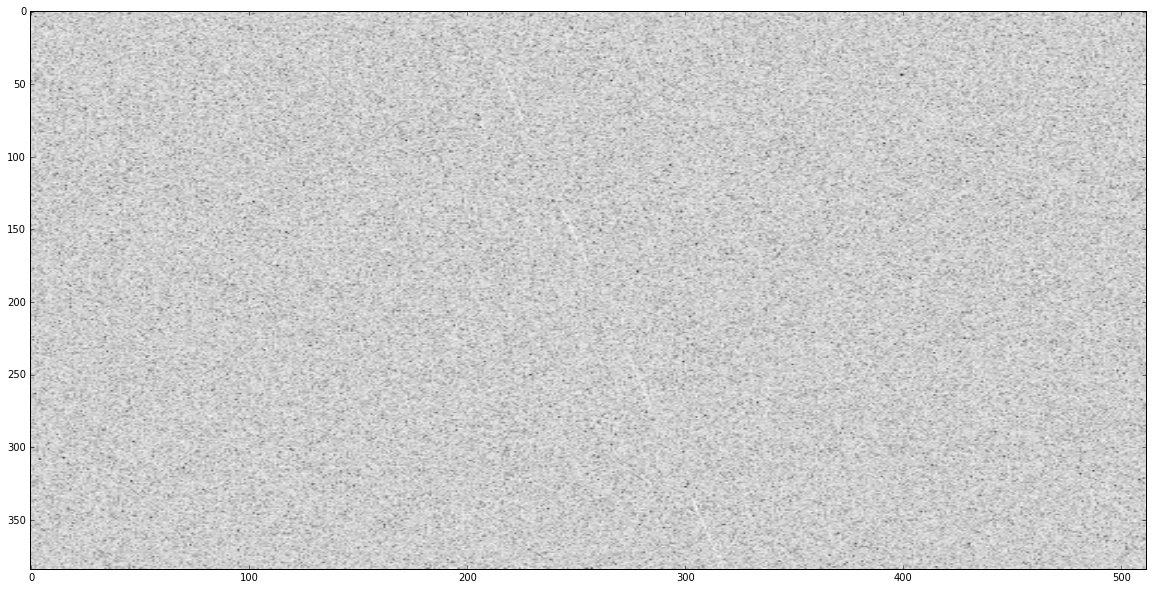

In [15]:
aca = ibmseti.compamp.SimCompamp(open(simfile,'rb').read())
spectrogram = aca.get_spectrogram()
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(np.log(spectrogram),  aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0], cmap='gray')

<br>
## Check the test set class from the published list of signal classes.

In [12]:
import pandas as pd
preview_test_set_pd = pd.read_csv('https://github.com/setiQuest/ML4SETI/raw/master/results/private_list_primary_v3_testset_preview_uuid_class_29june_2017.csv', index_col=None)

In [13]:
expected_signal_class = preview_test_set_pd[preview_test_set_pd.UUID == simfile.split('/')[-1].rstrip('.dat')].SIGNAL_CLASSIFICATION.values[0]

In [14]:
assert predicted_signal_class == expected_signal_class
print(expected_signal_class)

squarepulsednarrowband
